## **1. Persiapan Data**

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=be4387c936217e20cde3fe7d4e76cddbad672bd0b30b9e19c9fb96f5b20448f7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, date_format
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Membuat objek SparkSession
spark = SparkSession.builder.appName("MonitoringKelembaban").getOrCreate()

# Mendefinisikan skema data
schema = StructType([
    StructField("Timestamp", StringType(), True),
    StructField("Kelembaban Tanah", DoubleType(), True),
    StructField("Waktu Pengamatan", StringType(), True),
    StructField("Hari Pengamatan", IntegerType(), True)
])

# Membaca data dari file CSV dengan skema yang didefinisikan
data = spark.read.option("header", "true").csv("data_tubes_abd.csv", schema=schema)

# Konversi kolom Timestamp menjadi tipe data timestamp
data = data.withColumn("Timestamp", to_timestamp(col("Timestamp"), "yyyy-MM-dd HH:mm:ss"))

# Membuat kolom baru untuk jam pengamatan
data = data.withColumn("Jam", hour(col("Timestamp")))

In [ ]:
data.show()

+-------------------+----------------+----------------+---------------+---+
|          Timestamp|Kelembaban Tanah|Waktu Pengamatan|Hari Pengamatan|Jam|
+-------------------+----------------+----------------+---------------+---+
|2024-05-03 07:00:00|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:01|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:02|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:03|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:04|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:05|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:06|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:07|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:08|            35.0|            Pagi|              1|  7|
|2024-05-03 07:00:09|            35.0|            Pagi|              1|  7|
|2024-05-03 

## **2. Eksplorasi Data dan Analisis Deskriptif**

In [ ]:
from pyspark.sql.functions import mean, stddev, min, max, count

# Menghitung statistik deskriptif
deskriptif = data.select(
    mean("Kelembaban Tanah").alias("Rata-rata"),
    stddev("Kelembaban Tanah").alias("Standar Deviasi"),
    min("Kelembaban Tanah").alias("Minimum"),
    max("Kelembaban Tanah").alias("Maksimum"),
    count("Kelembaban Tanah").alias("Total Pengamatan")
).collect()

print("Statistik Deskriptif:")
print(deskriptif)

# Menghitung statistik deskriptif berdasarkan waktu pengamatan
deskriptif_waktu = data.groupBy("Waktu Pengamatan").agg(
    mean("Kelembaban Tanah").alias("Rata-rata"),
    stddev("Kelembaban Tanah").alias("Standar Deviasi")
).orderBy("Waktu Pengamatan")

print("\nStatistik Deskriptif Berdasarkan Waktu Pengamatan:")
deskriptif_waktu.show()

Statistik Deskriptif:
[Row(Rata-rata=41.94566666666667, Standar Deviasi=18.72982847682751, Minimum=20.0, Maksimum=93.0, Total Pengamatan=30000)]

Statistik Deskriptif Berdasarkan Waktu Pengamatan:
+----------------+------------------+------------------+
|Waktu Pengamatan|         Rata-rata|   Standar Deviasi|
+----------------+------------------+------------------+
|           Malam| 67.99253333333333| 16.64199722765028|
|            Pagi| 41.30453333333333|3.9379513003101394|
|           Siang|22.510666666666665|1.4382496412281687|
|            Sore| 35.97493333333333| 4.058238645316822|
+----------------+------------------+------------------+



## **3. Analisis Pola Tren Kelembaban Tanah**

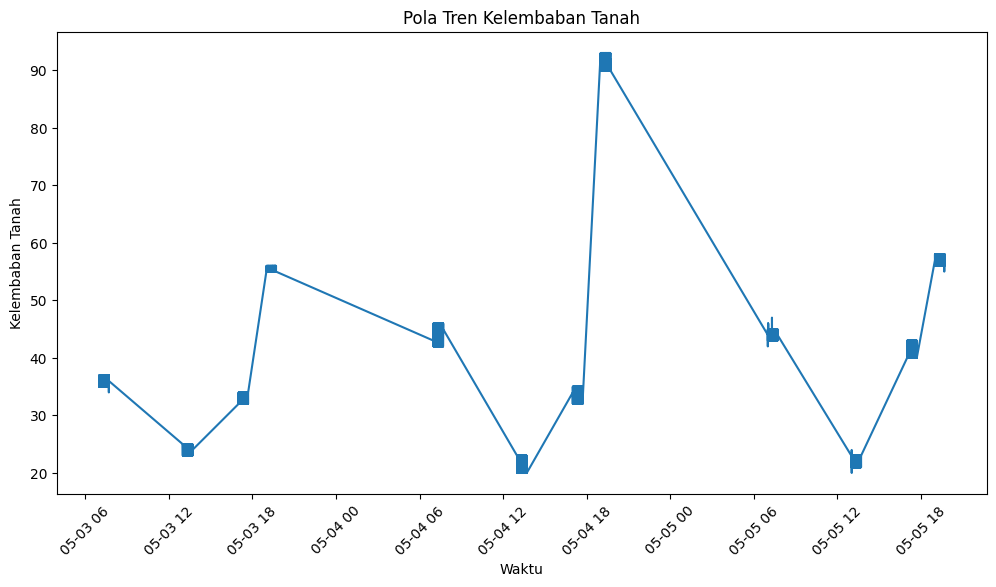

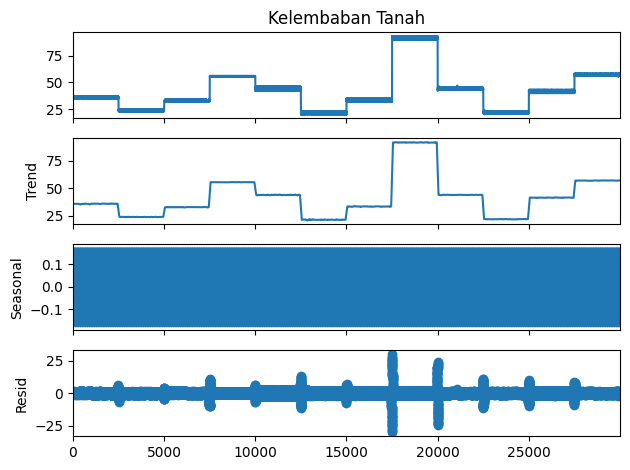

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Konversi DataFrame Spark menjadi DataFrame Pandas
pdf = data.toPandas()

# Visualisasi time-series
plt.figure(figsize=(12, 6))
sns.lineplot(x="Timestamp", y="Kelembaban Tanah", data=pdf)
plt.title("Pola Tren Kelembaban Tanah")
plt.xlabel("Waktu")
plt.ylabel("Kelembaban Tanah")
plt.xticks(rotation=45)
plt.show()

# Dekomposisi time-series menggunakan statsmodels
result = seasonal_decompose(pdf["Kelembaban Tanah"], model="additive", period=96)

# Visualisasi komponen tren, musiman, dan residu
result.plot()
plt.show()

## **4. Pemodelan dan Prediksi Kelembaban Tanah**

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Mengkodekan kolom kategorikal menjadi indeks numerik
waktu_indexer = StringIndexer(inputCol="Waktu Pengamatan", outputCol="Waktu Pengamatan Encoded")
hari_indexer = StringIndexer(inputCol="Hari Pengamatan", outputCol="Hari Pengamatan Encoded")

# Menggabungkan semua fitur ke dalam vektor
assembler = VectorAssembler(inputCols=["Kelembaban Tanah", "Waktu Pengamatan Encoded", "Hari Pengamatan Encoded", "Jam"], outputCol="features")

# Memisahkan data menjadi data latih dan data uji
(data_latih, data_uji) = data.randomSplit([0.8, 0.2], seed=42)

# Transformasi data latih untuk membuat kolom "features"
waktu_indexer_model = waktu_indexer.fit(data_latih)
data_latih = waktu_indexer_model.transform(data_latih)
hari_indexer_model = hari_indexer.fit(data_latih)
data_latih = hari_indexer_model.transform(data_latih)
data_latih = assembler.transform(data_latih)

# Membangun model Random Forest Regressor
rf = RandomForestRegressor(labelCol="Kelembaban Tanah", featuresCol="features")

# Melakukan tuning parameter menggunakan Cross-Validation
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()
evaluator = RegressionEvaluator(labelCol="Kelembaban Tanah", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Melatih model dengan parameter terbaik
model = cv.fit(data_latih)

# Transformasi data uji untuk membuat kolom "features"
data_uji = waktu_indexer_model.transform(data_uji)
data_uji = hari_indexer_model.transform(data_uji)
data_uji = assembler.transform(data_uji)

# Melakukan prediksi pada data uji
prediksi = model.transform(data_uji)

# Mengevaluasi performa model
rmse = evaluator.evaluate(prediksi)
print(f"Root Mean Squared Error (RMSE) pada data uji: {rmse:.2f}")

Root Mean Squared Error (RMSE) pada data uji: 1.09


In [ ]:
# Mengevaluasi performa model
rmse = evaluator.evaluate(prediksi)
print(f"Root Mean Squared Error (RMSE) pada data uji: {rmse:.2f}")

Root Mean Squared Error (RMSE) pada data uji: 1.09


In [ ]:
prediksi

DataFrame[Timestamp: timestamp, Kelembaban Tanah: double, Waktu Pengamatan: string, Hari Pengamatan: int, Jam: int, Waktu Pengamatan Encoded: double, Hari Pengamatan Encoded: double, features: vector, prediction: double]

In [ ]:
prediksi.show()

+-------------------+----------------+----------------+---------------+---+------------------------+-----------------------+------------------+------------------+
|          Timestamp|Kelembaban Tanah|Waktu Pengamatan|Hari Pengamatan|Jam|Waktu Pengamatan Encoded|Hari Pengamatan Encoded|          features|        prediction|
+-------------------+----------------+----------------+---------------+---+------------------------+-----------------------+------------------+------------------+
|2024-05-03 07:00:02|            35.0|            Pagi|              1|  7|                     1.0|                    0.0|[35.0,1.0,0.0,7.0]| 35.60463249769123|
|2024-05-03 07:00:06|            35.0|            Pagi|              1|  7|                     1.0|                    0.0|[35.0,1.0,0.0,7.0]| 35.60463249769123|
|2024-05-03 07:00:08|            35.0|            Pagi|              1|  7|                     1.0|                    0.0|[35.0,1.0,0.0,7.0]| 35.60463249769123|
|2024-05-03 07:00:13| 

In [ ]:
from pyspark.sql.functions import mean, stddev, min, max, count

# Menghitung statistik deskriptif
deskriptif = prediksi.select(
    mean("Kelembaban Tanah").alias("Rata-rata"),
    stddev("Kelembaban Tanah").alias("Standar Deviasi"),
    min("Kelembaban Tanah").alias("Minimum"),
    max("Kelembaban Tanah").alias("Maksimum"),
    count("Kelembaban Tanah").alias("Total Pengamatan")
).collect()

print("Statistik Deskriptif:")
print(deskriptif)

# Menghitung statistik deskriptif berdasarkan waktu pengamatan
deskriptif_waktu = prediksi.groupBy("Waktu Pengamatan").agg(
    mean("Kelembaban Tanah").alias("Rata-rata"),
    stddev("Kelembaban Tanah").alias("Standar Deviasi")
).orderBy("Waktu Pengamatan")

print("\nStatistik Deskriptif Berdasarkan Waktu Pengamatan:")
deskriptif_waktu.show()

Statistik Deskriptif:
[Row(Rata-rata=41.90583109919571, Standar Deviasi=18.81540913082874, Minimum=20.0, Maksimum=93.0, Total Pengamatan=5968)]

Statistik Deskriptif Berdasarkan Waktu Pengamatan:
+----------------+------------------+------------------+
|Waktu Pengamatan|         Rata-rata|   Standar Deviasi|
+----------------+------------------+------------------+
|           Malam|  68.0804828973843| 16.67663925014285|
|            Pagi|41.493197278911566|  3.84001290317119|
|           Siang|22.548114434330298|1.4199387699875272|
|            Sore|36.019060585432264| 4.069346624543834|
+----------------+------------------+------------------+

